# EA-CSP-TCA

In [1]:
import sys
sys.path.append('D:\Google_Drive\JupyterNotebookProjects\bci-research\EA+CSP+TCA\csp')
sys.path.append('D:\Google_Drive\JupyterNotebookProjects\bci-research\EA+CSP+TCA\func')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import moabb.datasets
import moabb.paradigms

from copy import deepcopy
from csp.utils import subject_counter
from csp.preprocess import fir_bandpass, apply_bandpass, fetch_left_right_EEG
from csp.preprocess import split_EEG_one_class, process_s_data
from csp.feat_extraction import compute_Z, feat_vector, true_label
from csp.csp import CSP

# Set float number print options
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
dframe = pd.DataFrame

In [3]:
# First import the data

# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
ns = 10

# Creating dict to store original data and modified data
# ori_data will serve as initial loaded data that will remain unchanged
ori_data = dict()
mod_data = dict() 

## Load Dataset

In [4]:
import os

# Iter over all data path then store them in sub0X variable
for subj in range(1, 10):
    path = '..\..\datasets\BCICIV2a'
    file = 'A{:02d}T.npz'.format(subj)
    data_path = os.path.join(path, file)
    
    # Load EEG data from datapath and store into subj0X variabel then store into ori_dict
    # Then also fetch 's' (EEG data) into mod_data
    ori_data[subj] = np.load(data_path)
    mod_data[subj] = {}
    mod_data[subj]['s'] = deepcopy(ori_data[subj]['s'])
    mod_data[subj]['etyp'] = deepcopy(ori_data[subj]['etyp'])
    mod_data[subj]['epos'] = deepcopy(ori_data[subj]['epos'])
    
    # Remove last three EOG electrodes
    mod_data[subj]['s'] = np.delete(mod_data[subj]['s'], np.s_[22:], 1)
    
    # Transpose s so that it's in shape of samples x n_electrodes
    mod_data[subj]['s'] = mod_data[subj]['s'].T

In [5]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos'])

## Preprocessing

### Bandpass Filter

In [6]:
from scipy.signal import firwin, freqs, lfilter

In [7]:
# Frequency sampling at 250Hz
fs = 250

## === Bandpass filter 8-39 Hz ====
# Creating coefficient
b = fir_bandpass(51, low=8, high=30, fs=fs)

# Applying filter
for subj in mod_data.keys():
    temp_raw_EEG = mod_data[subj]['s']
    
    assert temp_raw_EEG.shape[0] < temp_raw_EEG.shape[1]
    
    mod_data[subj]['s_filt'] = apply_bandpass(temp_raw_EEG, b)

### Convert n_samp x n_el -> n_trials x n_el x n_samp

In [8]:
# Iterate overall all_data
for subj in mod_data.keys():
    print('Processing for subject', subj)
    mod_data[subj]['epochs'], mod_data[subj]['y'], _ = process_s_data(data=mod_data[subj], eeg_key='s_filt', start_t=0.5, end_t=3.5, fs=250)
    
    # Make sure they are in correct size
    assert mod_data[subj]['epochs'].shape[0] == 144
    assert mod_data[subj]['epochs'].shape[1] == 22
    assert mod_data[subj]['epochs'].shape[2] > 144    

Processing for subject 1
Processing for subject 2
Processing for subject 3
Processing for subject 4
Processing for subject 5
Processing for subject 6
Processing for subject 7
Processing for subject 8
Processing for subject 9


## Apply Data Alignment on raw EEG

In [9]:
from func.EA import apply_EA
from func.csp_matlab import csp_feat_ver1

In [10]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 's_filt', 'epochs', 'y'])

In [11]:
%%capture
# Iterate over all subjects to apply EA to all trials
# Define keys to be processed
process_key = ['epochs']

for subj in mod_data.keys():
    print('Processing subject ', subj)
    mod_data[subj]['epochs_EA']  = apply_EA(mod_data[subj], process_key)
    print('')

In [12]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 's_filt', 'epochs', 'y', 'RefEA', 'R_inv', 'epochs_EA'])

In [13]:
# Sanity check that each subject EA data equal to identity matrix
for subj in mod_data.keys():
    all_trials = mod_data[subj]['epochs_EA']
    all_cov = 0
    
    for tr in all_trials:
        all_cov += np.cov(tr, rowvar=True, ddof=1)
    
    all_cov = all_cov/len(all_trials)
    
    assert np.round(np.diag(all_cov)).sum() == 22
    print('Subject %d Aligned!' %subj)

Subject 1 Aligned!
Subject 2 Aligned!
Subject 3 Aligned!
Subject 4 Aligned!
Subject 5 Aligned!
Subject 6 Aligned!
Subject 7 Aligned!
Subject 8 Aligned!
Subject 9 Aligned!


# Visualizing using T-SNE
Skip visualization

In [14]:
from sklearn.manifold import TSNE
from func.csp_matlab import csp_feat_no_test

In [15]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 's_filt', 'epochs', 'y', 'RefEA', 'R_inv', 'epochs_EA'])

In [16]:
data = mod_data

for subj in data.keys():
    # Compute csp feature
    data[subj]['all_feats'] = csp_feat_no_test(data[subj], eeg_key='epochs')
    data[subj]['all_feats_EA'] = csp_feat_no_test(data[subj], eeg_key='epochs_EA')
    
    # Compute sne representation
    # data[subj]['sne'] = {}
    # data[subj]['sne']['no_EA'] = TSNE(perplexity=50, n_iter=2000, random_state=42).fit_transform(data[subj]['all_feats'])
    # data[subj]['sne']['EA'] = TSNE(perplexity=50, n_iter=2000, random_state=42).fit_transform(data[subj]['all_feats_EA'])

In [17]:
for subj in mod_data.keys():
    assert mod_data[subj]['all_feats'].shape[0] == 144
    assert mod_data[subj]['all_feats_EA'].shape[0] == 144 

# Transfer Learning Case, CSP + TCA

In [18]:
# Re-prepare data, redefine TL_data, delete existing content
TL_data = {}
TL_data['tgt'] = {}
TL_data['src'] = {}

for subj in mod_data.keys():
    # TARGET
    TL_data['tgt'][subj] = {}
    TL_data['tgt'][subj]['epochs'] = deepcopy(mod_data[subj]['epochs'])
    TL_data['tgt'][subj]['epochs_EA'] = deepcopy(mod_data[subj]['epochs_EA'])
    TL_data['tgt'][subj]['all_feats'] = deepcopy(mod_data[subj]['all_feats'])
    TL_data['tgt'][subj]['all_feats_EA'] = deepcopy(mod_data[subj]['all_feats_EA'])
    TL_data['tgt'][subj]['y'] = deepcopy(mod_data[subj]['y'])    
    
    # SOURCE
    TL_data['src'][subj] = {}
    TL_data['src'][subj]['epochs']    = deepcopy(mod_data[subj]['epochs'])
    TL_data['src'][subj]['epochs_EA'] = deepcopy(mod_data[subj]['epochs_EA'])
    TL_data['src'][subj]['all_feats']     = deepcopy(mod_data[subj]['all_feats'])
    TL_data['src'][subj]['all_feats_EA']  = deepcopy(mod_data[subj]['all_feats_EA'])
    TL_data['src'][subj]['y'] = deepcopy(mod_data[subj]['y'])    

In [19]:
TL_data['src'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

## `MMD`

In [20]:
# Compute MMD (maximum mean discrepancy) using numpy and scikit-learn.

import numpy as np
from sklearn import metrics


def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)


def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()


def mmd_poly(X, Y, degree=2, gamma=1, coef0=0):
    """MMD using polynomial kernel (i.e., k(x,y) = (gamma <X, Y> + coef0)^degree)
    Arguments:a
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        degree {int} -- [degree] (default: {2})
        gamma {int} -- [gamma] (default: {1})
        coef0 {int} -- [constant item] (default: {0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.polynomial_kernel(X, X, degree, gamma, coef0)
    YY = metrics.pairwise.polynomial_kernel(Y, Y, degree, gamma, coef0)
    XY = metrics.pairwise.polynomial_kernel(X, Y, degree, gamma, coef0)
    return XX.mean() + YY.mean() - 2 * XY.mean()

## `TCA`

In [21]:
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier

def kernel(ker, X1, X2, degree=3, gamma=1, coef=1):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        print(f'=== {ker} kernel ===')
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        print(f'=== {ker} kernel ===')
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
            
    elif ker == 'poly':
        print(f'=== {ker} kernel ===')
        if X2 is not None:
            K = sklearn.metrics.pairwise.polynomial_kernel(np.asarray(X1).T, np.asarray(X2).T, degree, gamma, coef)
        else:
            K = sklearn.metrics.pairwise.polynomial_kernel(np.asarray(X1).T, None, degree, gamma, coef)
            
    return K

In [242]:
# === TCA modified from original the following: ===
# - handles incremental target data, + coef
# - degree param
# - with SVM classifier
# - only returned real tca features (complex value may occurs when using linear kernel)

class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1, coef=1, degree=3):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim    = dim
        self.lamb   = lamb
        self.gamma  = gamma
        self.coef   = coef
        self.degree = degree
        self.W_proj = None
        self.X_src2 = None
        self.clf = None

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma, coef=self.coef, degree=self.degree)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Z /= np.linalg.norm(Z, axis=0)
        
        # Save projection matrix and X as new source
        self.W_proj  = A
        self.X_src2 = X
        
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new.real, Xt_new.real

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        
        # Store classifier, then save
        clf = SVC()
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        
        self.clf = clf
        return acc, y_pred

    def fit_new(self, Xt2):
        '''
        Map Xt2 to the latent space created from Xt and Xs in .fit
        Using existing W_proj and X_src2
        :param Xs : ns * n_feature, source feature
        :param Xt : nt * n_feature, target feature
        :param Xt2: n_s, n_feature, target feature to be mapped
        :return: Xt2_new, mapped Xt2 with projection created by Xs and Xt
        '''
        if not np.all(self.W_proj):
            raise AssertionError('No projection matrix found, use .fit to find projectino matrix, feature of source and target')
        
        # Reshape to make it consistent with other methods
        Xt2 = Xt2.T

        # Compute kernel with respect to self.X_new_src
        K = kernel(self.kernel_type, X1 = Xt2, X2 = self.X_src2, gamma=self.gamma)

        # New target features
        Xt2_new = K @ self.W_proj

        return Xt2_new.real
    
    def fit_predict_new(self, Xt2, Yt2):
        '''
        Transfrom Xt and Xs, get Xs_new
        Transform Xt2 with projection matrix created by Xs and Xt, get Xt2_new
        Make predictions on Xt2_new using classifier trained on Xs_new
        :param Xt: ns * n_feature, target feature
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt2: nt * n_feature, new target feature
        :param Yt2: nt * 1, new target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        if not np.all(self.W_proj) or not np.all(self.clf) :
            raise AssertionError('No classifier found, trained classifier first using .fit_predict')

        Xt2_new = self.fit_new(Xt2)

        y_pred = self.clf.predict(Xt2_new)
        acc = sklearn.metrics.accuracy_score(Yt2, y_pred)

        return acc, y_pred

In [177]:
# Function to convert score and std to +/- form
conv = lambda sc, std: str(np.round(sc, 2)) + ' +/- ' + str(np.round(std, 2))
# print(conv(80.356, 0.5678))

In [192]:
tca_ker = 'linear'
tca_dim = 3

tca = TCA(kernel_type=tca_ker, dim=tca_dim, lamb=1, gamma=1, coef=1, degree=3)

In [193]:
_, _ = tca.fit_predict(Xs, Ys, Xt1, Yt1)

=== linear kernel ===


In [194]:
tca.W_proj.shape

(164, 3)

In [195]:
tca.clf

SVC()

In [196]:
tca.X_src2.shape

(6, 164)

In [199]:
acc, _ = tca.fit_predict_new(Xt2, Yt2)
acc

=== linear kernel ===


0.3

In [165]:
Ys

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

## `evaluate-all` function 7
**Main idea** :   
Found out about how to do update on incremental data, this class will caters about that as well.
The following method will be evaluate:
- CSP-SVM
- EA-CSP-SVM
- CSP-TCA-SVM
- EA-CSP-TCA-SVM

Separate function and class, the function will handle data separation, the class `eval7` will handle evaluation on specified model.

**Pseudocode**:
1. Function `eval_all_ver7` will accept the following parameter:
    - data    : data consisting of source and target
    - tgt_subj: subject act as target data
    - model   : model to be evaluated
    - tca_ker : kernel of tca
    - tca_dim : dim of tca
    - svm_ker : kernel of svm
    - n_tgt1  : random n of xt1
    - n_tgt2  : random n of xt2
    - n_sim   : n similar source to be paired with xt1 or xt2
    - n_src   : random n of src
    
    
2. Function `eval_all_ver7` will do the following:
    - Xt_raw and Yt : whether ori or EA-ed data
    - Xt1, Xt2 : randomized stratify Yt
    - csp_xt2 = csp(Xt2, Yt2) and csp_xt1 = csp(Xt1, Yt1)
    - csp_xs of all subjects
    - distance, MMD of csp_xt1 to all csp_xs
    - distance, MMD of csp_xt2 to all csp_xs
    - pass all this info to class `eval7`
  
    
2. Class `eval7` will have following attribute:
    - tca_kernel, tca_dimension, svm_kernel
    - Xs, Xt1, Xt2
    - csp_xs, csp_xt1, csp_xt2
    - mmd_xt1, mmd_xt2
    - Ys, Yt1, Yt2
    - tca_kern, svm_kern
    - tca_dim

In [43]:
# class Eval7():
#     def __init__(self, tca_kernel, tca_dimension, csp_xt1, csp_xt2, csp_xs)
#         self.tca_kern = tca_kernel
#         self.tca_dim  = tca_dimension
    
#     def csp_tca_svm_old():
        
#     def csp_tca_svm_new():
#         tca = TCA(kernel_type='self.tca_kern', dim=30, lamb=1, gamma=1, coef=1, degree=3)
#         tca.fit_predict_new()

In [37]:
import random
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from func.csp_matlab import csp_feat_no_test_2

In [305]:
def eval_all_ver7(data, tgt_subj=1, model='CSP-TCA-SVM', tca_ker='linear',\
                  tca_dim=3, svm_ker='linear', n_tgt1=20, n_tgt2=30, n_sim=3, n_src=144):
    
    print(f'Processing target subject: {tgt_subj}')
    print(f'Model: {model}') 
    
    # Key to define where data is stored
    all_keys=['epochs', 'epochs_EA', 'y']
    key_noEA = all_keys[0]
    key_EA = all_keys[1]    
    y = all_keys[2]
    
    # =========== PREPROCESSING  ============== #
    '''
    This section will fetch raw data to be evaluated
    '''
    # Following models need to fetch source EA data
    model_EA = ['EA-CSP-TCA-SVM', 'EA-CSP-SVM']
    
    # === EA data ====
    if model in model_EA:
        # Set key variable in which EA data is stored
        key = key_EA
        csp_feat_key = 'all_feats_EA'
        print(f'Fetching raw data stored in {key} csp_feat in {csp_feat_key}')

    # === no EA ===
    else:
        # Set key variable in which non-EA data is stored
        key = key_noEA
        csp_feat_key = 'all_feats'
        print(f'Fetching raw data stored in {key} csp_feat in {csp_feat_key}')
    
    # === Raw data of target ==== #
    Xraw_tgt = deepcopy(data['tgt'][tgt_subj][key])
    y_tgt    = deepcopy(data['tgt'][tgt_subj]['y'])
    
    # ===== N random target1 and target2 sample ==== #
    # == Target 1 ==
    idx = random.sample(range(len(Xraw_tgt)), n_tgt1)
    while (y_tgt[idx] == 1).sum() != n_tgt1//2:
        idx = random.sample(range(len(Xraw_tgt)), n_tgt1)

    Xraw_tgt1 = Xraw_tgt[idx]
    y_tgt1    = y_tgt[idx]
    
    Xraw_tgt_left = np.delete(Xraw_tgt, idx, axis=0)
    y_tgt_left    = np.delete(y_tgt, idx, axis=0)
    
    # == Target 2 ==
    idx = random.sample(range(len(Xraw_tgt_left)), n_tgt2)
    while (y_tgt[idx] == 1).sum() != n_tgt2//2:
        idx = random.sample(range(len(Xraw_tgt_left)), n_tgt2)
        
    Xraw_tgt2 = Xraw_tgt_left[idx]
    y_tgt2    = y_tgt_left[idx]
    
    # == CSP Xraw_tgt1 and Xraw_tgt2 ==
    csp_tgt_self_1 = csp_feat_no_test_2(Xraw_tgt1, y_tgt1, n_filter=3)
    csp_tgt_self_2 = csp_feat_no_test_2(Xraw_tgt2, y_tgt2, n_filter=3)
    
    # == Compute MMD csp_tgt1 and csp_tgt2 ==
    n_sim_sub_tgt1 = mmd_to_src(data, tgt_subj, csp_tgt_self_1, csp_feat_key, n_sim_sub=n_sim)
    n_sim_sub_tgt2 = mmd_to_src(data, tgt_subj, csp_tgt_self_2, csp_feat_key, n_sim_sub=n_sim)    
    
    print(f'MMD result {n_sim} most similar subject to csp_tgt1 of target {tgt_subj} : {n_sim_sub_tgt1}')
    
    # Variable to store best score from similar source subject
    best_sc = 0
    
    # ==== CSP-TCA-SVM-C ==== # 
    if model == 'CSP-TCA-SVM-C' or model == 'EA-CSP-TCA-SVM-C':
        print(f'Evaluating {model}')
        # Iterate over n similar subjects
        for sim_subj in n_sim_sub_tgt1:
            # Raw data of most similar subject
            Xraw_src = data['src'][sim_subj][key]
            y_src    = data['src'][sim_subj][y] 

            # CSP of Xraw_tgt1 and Xraw_tgt2 with filter from Xraw_src 
            csp_src, csp_tgt1 = csp_feat_ver1(Xraw_src, Xraw_tgt1, y_src, n_filter=3)
            _      , csp_tgt2 = csp_feat_ver1(Xraw_src, Xraw_tgt2, y_src, n_filter=3)

            tca = TCA(kernel_type=tca_ker, dim=tca_dim, lamb=1, gamma=1, coef=1, degree=3)
            _, _ = tca.fit_predict(csp_src, y_src, csp_tgt1, y_tgt1)
            temp_sc, _ = tca.fit_predict_new(csp_tgt2, y_tgt2)

            best_sc = temp_sc if temp_sc > best_sc else best_sc

            
#     # ==== CSP-TCA-SVM-C ==== # 
#     if model == 'CSP-TCA-SVM-C' or model == 'EA-CSP-TCA-SVM-C':
#         print(f'Evaluating {model}')
#         # Iterate over n similar subjects
#         for sim_subj in n_sim_sub_tgt1:
#             # Raw data of most similar subject
#             Xraw_src = data['src'][sim_subj][key]
#             y_src    = data['src'][sim_subj][y] 

#             # CSP of Xraw_tgt1 and Xraw_tgt2 with filter from Xraw_src 
#             csp_src, csp_tgt1 = csp_feat_ver1(Xraw_src, Xraw_tgt1, y_src, n_filter=3)
#             _      , csp_tgt2 = csp_feat_ver1(Xraw_src, Xraw_tgt2, y_src, n_filter=3)
            
#             # Perform TCA
#             tca = TCA(kernel_type=tca_ker, dim=tca_dim, lamb=1, gamma=1, coef=1, degree=3)
#             _, _       = tca.fit_predict(csp_src, y_src, csp_tgt1, y_tgt1)
#             temp_sc, _ = tca.fit_predict_new(csp_tgt2, y_tgt2)

#             best_sc = temp_sc if temp_sc > best_sc else best_sc

    
    return best_sc
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        

#         ## =========== EVALUATION =========== ##
#         # ====== CSP-SVM ====== #
#         if (model == 'CSP-SVM') or (model == 'EA-CSP-SVM'):
#             print(f'Evaluating {model}')
#             print(f'Similar subject: {sim_subj}')
#             print(f'train size {csp_src.shape}')
#             print(f'test size  {csp_tgt_test.shape}')

#             # Define classifier
#             model_svm = SVC(kernel=svm_ker, coef0=1)

#             # Fitting data
#             model_svm.fit(csp_src, y_src)

#             # Current score
#             sc = model_svm.score(csp_tgt_test, y_tgt_te)
#             print(f'Source{sim_subj} current score: {sc:.2f}')

#             # Storing the best score
#             best_sc = sc if sc > best_sc else best_sc


#         # ====== EA, CSP-TCA-SVM ====== #
#         elif (model == 'CSP-TCA-SVM') or (model=='EA-CSP-TCA-SVM'):   
#             # ====== TCA ====== #
#             print(f'Evaluating {model}')
#             # Compute TCA feature of current target and most similar subject
#             tca = TCA(kernel_type=tca_ker, dim=tca_dim, lamb=1, gamma=1, coef=1, degree=3)

#             # print('=== Training classifier ===')
#             print('Find new TCA feature using following data')
#             print('CSP src all     : ', csp_src.shape)
#             print('CSP tgt test    : ', csp_tgt_test.shape)

#             tca_src, tca_tgt_test = tca.fit(csp_src, csp_tgt_test)

#             # --- Training ----- #
#             # Define new classifier
#             model_svm = SVC(kernel=svm_ker, coef0=1)

#             # Fiting data
#             model_svm.fit(tca_src.real, y_src)

#             # Current score
#             sc = model_svm.score(tca_tgt_test.real, y_tgt_te)

#             # Storing the best score
#             best_sc = sc if sc > best_sc else best_sc

#         print('')
        
#         # Out of similar subject loop, append each best_sc 
#         all_sc.append(best_sc*100)

In [306]:
models = ['CSP-TCA-SVM-C'] #, 'CSP-TCA-SVM-C']
data = TL_data
n_iter = 1
all_sc7 = {}

for m in models:
    print(m)
    all_sc7[m] = {}
    
#     for t in data['tgt'].keys():
    for t in [1]:
        all_sc7[m][t] = []
        
        for i in range(n_iter):
            sc = eval_all_ver7(data, tgt_subj=t, model=m, tca_ker='rbf', \
                               tca_dim=3, svm_ker='rbf', n_tgt1=20, n_tgt2=50, n_sim=3, n_src=144)
    
            all_sc7[m][t].append(sc)

CSP-TCA-SVM-C
Processing target subject: 1
Model: CSP-TCA-SVM-C
Fetching raw data stored in epochs csp_feat in all_feats
sim subj: [6 7 3]
sim subj: [7 6 2]
MMD result 3 most similar subject to csp_tgt1 of target 1 : [6 7 3]
Evaluating CSP-TCA-SVM-C
=== rbf kernel ===
=== rbf kernel ===
=== rbf kernel ===
=== rbf kernel ===
=== rbf kernel ===
=== rbf kernel ===


In [307]:
all_sc7['CSP-TCA-SVM-B'][1]

KeyError: 'CSP-TCA-SVM-B'

In [283]:
print(sc1)
print(sc2)

[0.52, 0.46, 0.82, 0.52, 0.54]
[0.64, 0.54, 0.5, 0.46, 0.46]


In [281]:
sc

0

In [114]:
def mmd_to_src(data, tgt_sub, csp_tgt, csp_feat_key, n_sim_sub):
    '''
    Built specifically to handle mi-bci TL case witl TCA
    :params:
    data     : data containing csp source data
    csp_tgt  : csp target data againts which distance will be measure
    n_sim_sub: pick n_most similar subj
    :return:
    sim_sub  : subject with the least mmd value, ie closest to csp_tgt
    '''
    # ===== Find most similar source to current target data ====== #
    # MMD from csp_tgt to rest of source
    mmd = []
    for src_subj in data['src'].keys():
        if src_subj == tgt_sub:
            mmd.append(0)
        else:
            csp_src = data['src'][src_subj][csp_feat_key]
            mmd.append(mmd_rbf(csp_src, csp_tgt))

    # Plus to because index starts from zero
    mmd_sim = np.argsort(np.array(mmd))+1    

    # Choose n_sim most simliar source to current target subject 
    n_sim_subj = mmd_sim[1:n_sim_sub+1] 
    # print(f'sim subj: {n_sim_subj}')
    
    return n_sim_subj

In [239]:
def eval_all_ver6(data, tgt_subj=1, model='CSP-SVM', n_sim=3, tca_ker='linear', svm_ker='linear', tca_dim=3, n_samp=10, n_iter=20, return_mean=False):
    '''
    
    '''
    print(f'Processing target subject: {tgt_subj}')
    print(f'Model: {model}')    
    
    # Key to define where data is stored
    all_keys=['epochs', 'epochs_EA', 'y']
    key_noEA = all_keys[0]
    key_EA = all_keys[1]    
    y = all_keys[2]
    
    # =========== PREPROCESSING  ============== #
    '''
    This section will fetch raw data to be evaluated
    '''
    # Following models need to fetch source EA data
    model_EA = ['EA-CSP-TCA-SVM', 'EA-CSP-SVM']
    
    # === EA data ====
    if model in model_EA:
        # Set key variable in which EA data is stored
        key = key_EA
        csp_feat = 'all_feats_EA'
        print('Fetching raw data stored in {}'.format(key))
        print('Fetching feat data stored in {}'.format(csp_feat))

    # === no EA ===
    else:
        # Set key variable in which non-EA data is stored
        key = key_noEA
        csp_feat = 'all_feats'
        print('Fetching raw data stored in {}'.format(key))
        print('Fetching feat data stored in {}'.format(csp_feat))
    
    # === Raw data of target ==== #
    Xraw_tgt = deepcopy(data['tgt'][tgt_subj][key])
    y_tgt    = deepcopy(data['tgt'][tgt_subj]['y'])
    
    # Object to store all result
    all_sc = []
    
    for i in range(n_iter):
        print('Iteration', i)
        
        # ===== Selecting n random target sample ==== #
        idx = random.sample(range(len(Xraw_tgt)), n_samp)
        while (y_tgt[idx] == 1).sum() != n_samp//2:
            idx = random.sample(range(len(Xraw_tgt)), n_samp)
        
        Xraw_tgt_test = Xraw_tgt[idx]
        y_tgt_te      = y_tgt[idx]
        
        # ===== Find most similar source to current target data ====== #
        # CSP of current Xraw_tgt_te
        csp_tgt_test = csp_feat_no_test_2(Xraw_tgt_test, y_tgt_te, n_filter=3)
        
        # MMD from current csp_tgt_train to rest of source
        mmd = []
        for src_subj in data['src'].keys():
            if src_subj == tgt_subj:
                mmd.append(0)
            else:
                csp_src = data['src'][src_subj][csp_feat]
                mmd.append(mmd_rbf(csp_src, csp_tgt_test))

        # Choose one subject most similar to current target
        mmd_sim = np.argsort(np.array(mmd))+1    

        # Choose n_sim most simliar source to current target subject 
        n_sim_subj = mmd_sim[1:n_sim+1] 

        print(f'mmd result: {mmd_sim}')
        print(f'sim subj: {n_sim_subj}')
        
        # Variable to store best score from each source subject
        best_sc = 0
            
        # Iterate over all similar subject
        for sim_subj in n_sim_subj:
            # Raw data of most similar subject
            Xraw_src = data['src'][sim_subj][key]
            y_src    = data['src'][sim_subj][y] 

            # CSP of Xraw_tgt with filter from Xraw_src 
            csp_src, csp_tgt_test = csp_feat_ver1(Xraw_src, Xraw_tgt_test, y_src, n_filter=3)
            
            
            ## =========== EVALUATION =========== ##
            # ====== CSP-SVM ====== #
            if (model == 'CSP-SVM') or (model == 'EA-CSP-SVM'):
                print(f'Evaluating {model}')
                print(f'Similar subject: {sim_subj}')
                print(f'train size {csp_src.shape}')
                print(f'test size  {csp_tgt_test.shape}')

                # Define classifier
                model_svm = SVC(kernel=svm_ker, coef0=1)

                # Fitting data
                model_svm.fit(csp_src, y_src)
                
                # Current score
                sc = model_svm.score(csp_tgt_test, y_tgt_te)
                print(f'Source{sim_subj} current score: {sc:.2f}')

                # Storing the best score
                best_sc = sc if sc > best_sc else best_sc
            

            # ====== EA, CSP-TCA-SVM ====== #
            elif (model == 'CSP-TCA-SVM') or (model=='EA-CSP-TCA-SVM'):   
                # ====== TCA ====== #
                print(f'Evaluating {model}')
                # Compute TCA feature of current target and most similar subject
                tca = TCA(kernel_type=tca_ker, dim=tca_dim, lamb=1, gamma=1, coef=1, degree=3)

                # print('=== Training classifier ===')
                print('Find new TCA feature using following data')
                print('CSP src all     : ', csp_src.shape)
                print('CSP tgt test    : ', csp_tgt_test.shape)

                tca_src, tca_tgt_test = tca.fit(csp_src, csp_tgt_test)

                # --- Training ----- #
                # Define new classifier
                model_svm = SVC(kernel=svm_ker, coef0=1)

                # Fiting data
                model_svm.fit(tca_src.real, y_src)

                # Current score
                sc = model_svm.score(tca_tgt_test.real, y_tgt_te)
                
                # Storing the best score
                best_sc = sc if sc > best_sc else best_sc
            
            print('')
        
        # Out of similar subject loop, append each best_sc 
        all_sc.append(best_sc*100)
        
        print('')
    
    # Out of iteration loop
    mean_sc = np.array(all_sc).mean()
    std_sc  = np.array(all_sc).std()
    
    if return_mean:
        return mean_sc, std_sc
    else:
        return all_sc

In [240]:
%%capture
# Store all score
all_sc6 = {}
# Models
# models = ['CSP-SVM', 'CSP-TCA-SVM', 'EA-CSP-SVM', 'EA-CSP-TCA-SVM']
models = ['CSP-TCA-SVM']
# models = ['CSP-SVM', 'CSP-TCA-SVM']

# Iterate over all tgt subj
for m in models:
    all_sc6[m]  = {}
    temp_sc = []
    
    for s in TL_data['tgt'].keys():
        avg, std = eval_all_ver6(TL_data, tgt_subj=s, tca_ker='rbf', svm_ker='rbf', tca_dim=4, model=m, n_sim=3, n_samp=30, n_iter=1, return_mean=True)
        temp_sc.append(avg)
        
        all_sc6[m][s] = conv(avg, std)
        
    all_sc6[m]['avg'] = conv(np.array(temp_sc).mean(), np.array(temp_sc).std())

In [27]:
df_sc6 = dframe(all_sc6)
df_sc6

,CSP-SVM,CSP-TCA-SVM,EA-CSP-SVM,EA-CSP-TCA-SVM
1,70.0 +/- 0.0,70.0 +/- 0.0,90.0 +/- 0.0,93.33 +/- 0.0
2,63.33 +/- 0.0,53.33 +/- 0.0,70.0 +/- 0.0,63.33 +/- 0.0
3,76.67 +/- 0.0,73.33 +/- 0.0,96.67 +/- 0.0,93.33 +/- 0.0
4,53.33 +/- 0.0,73.33 +/- 0.0,80.0 +/- 0.0,56.67 +/- 0.0
5,53.33 +/- 0.0,53.33 +/- 0.0,60.0 +/- 0.0,60.0 +/- 0.0
6,70.0 +/- 0.0,76.67 +/- 0.0,66.67 +/- 0.0,73.33 +/- 0.0
7,50.0 +/- 0.0,80.0 +/- 0.0,73.33 +/- 0.0,73.33 +/- 0.0
8,96.67 +/- 0.0,93.33 +/- 0.0,90.0 +/- 0.0,96.67 +/- 0.0
9,66.67 +/- 0.0,66.67 +/- 0.0,80.0 +/- 0.0,76.67 +/- 0.0
avg,66.67 +/- 13.61,71.11 +/- 11.86,78.52 +/- 11.45,76.3 +/- 14.27


## `n-dim-tca` vs `acc`
**Goal**: Whether the dimensionality of tca space could affect accuracy?

**Concern:**: 
* Range of dimension? for now 1 to n-dim original
* The method that use tca-dim are CSP-TCA-SVM and EA-CSP-TCA-SVM

In [230]:
%%capture
# Iterate each subject over different dimension
tcadim_sc = {}
n_iter    = 3
models  = ['CSP-TCA-SVM', 'EA-CSP-TCA-SVM']
csp_dim = TL_data['src'][1]['all_feats'].shape[1]

for m in models:
    tcadim_sc[m] = {}
    
    for s in TL_data['tgt'].keys():
        tcadim_sc[m][s] = {}
        
        # Modify tca dimension from 1 to max of csp features
        for dim in range(1, csp_dim+1):
            tcadim_sc[m][s][dim] = eval_all_ver6(TL_data, tgt_subj=s, tca_ker='linear', svm_ker='rbf', \
                                                      tca_dim=dim, model=m, n_sim=3, n_samp=30, n_iter=n_iter, return_mean=False)

In [231]:
# Creating long-format data
tcadim_long = pd.DataFrame()

# Iterate over all models and subjects
for m in models:
    df_all_subj = pd.DataFrame()
    
    for s in TL_data['tgt'].keys():
        temp_df = pd.DataFrame(tcadim_sc[m][s])
        temp_df['model']  = m
        temp_df['subj'] = s
        temp_df.index.name   ='iter'
        temp_df.columns.name ='ndim'
        temp_df = temp_df.melt(id_vars=['subj', 'model'], value_vars=list(range(1, csp_dim+1)), value_name='acc', var_name='ndim', ignore_index=False)
        
        # Concatenate all subject
        df_all_subj = pd.concat([df_all_subj, temp_df])
    
    # Concatenate all models
    tcadim_long = pd.concat([tcadim_long, df_all_subj])

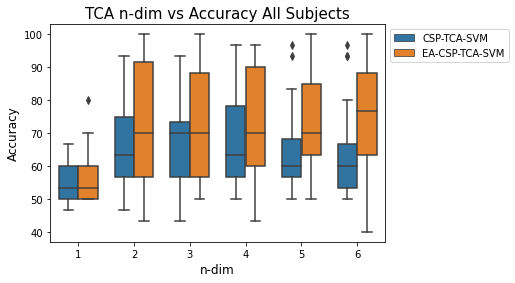

In [232]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=tcadim_long, x='ndim', y='acc', hue='model', width=.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('TCA n-dim vs Accuracy All Subjects', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('n-dim', fontsize=12)
plt.show()

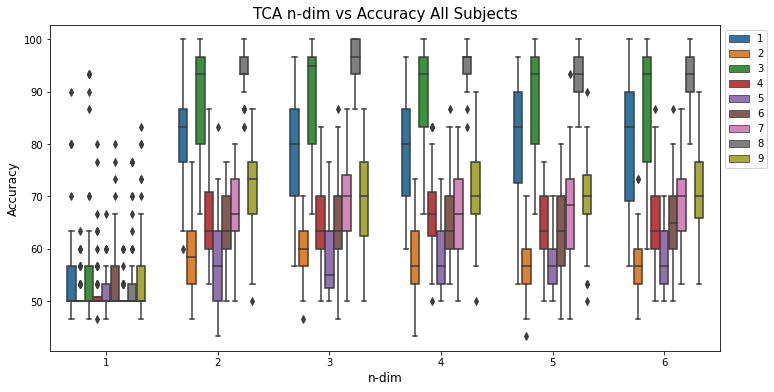

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(data=tcadim_long, x='ndim', y='acc', hue='subj', width=.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('TCA n-dim vs Accuracy All Subjects', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('n-dim', fontsize=12)
plt.show()

In [38]:
def create_df_each_subject(data):
    '''
    Parameters
    data   : dict type, containing [model][subject][iteration]
             score of each iteration, each subject, each model
    
    Return
    return : dataframe, will be store in data['df']
    '''
    if not all([np.int == type(k) for k in data.keys()]):
        return 'invalid, data containing str keys'
    
    
    df = pd.DataFrame(data)
    df.index.name = 'iter'
    df.columns.name= 'ndim'
    return df

In [39]:
# Copy tcadim_sc
data_copy = deepcopy(tcadim_sc)

# Constructing dataframe for each subject
for m in models:
    for s in TL_data['tgt'].keys():
        data_copy[m][s]['df'] = create_df_each_subject(data_copy[m][s])
        
    assert 'df' in (data_copy[m][s].keys())

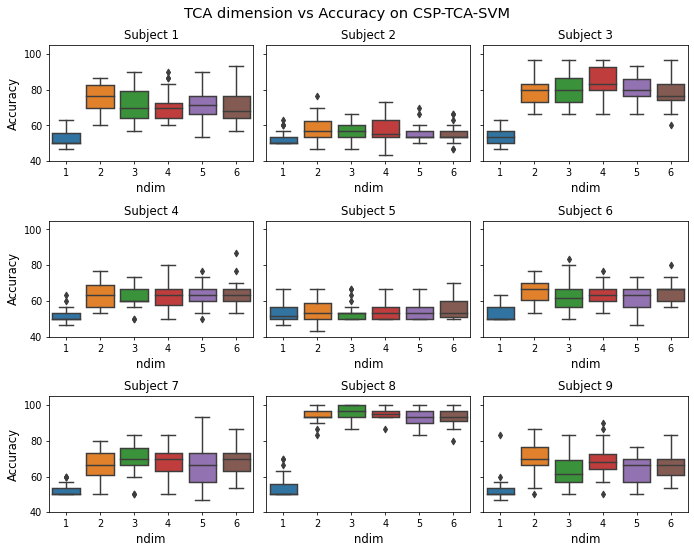

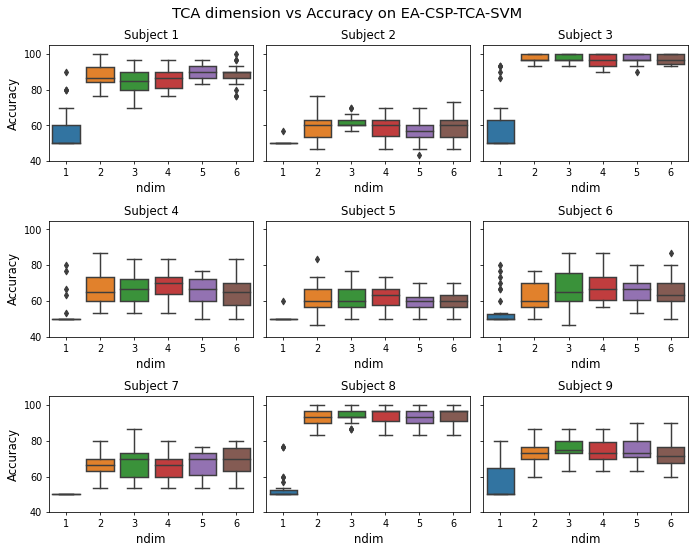

In [40]:
## ======== Boxplot of TCA-dim vs Acc Each Subject Separate Models ======== ##
# Necessary variables
nrow, ncol = 3, 3
models = ['CSP-TCA-SVM', 'EA-CSP-TCA-SVM']
m = models[0]
data = data_copy

# For each model
for m in models:
    # Plot
    fig, axes = plt.subplots(nrow, ncol, figsize=(10, 8), dpi=70, sharey=True)
    fig.suptitle(f'TCA dimension vs Accuracy on {m}', fontsize='15')

    for ax, s in zip(axes.ravel(), TL_data['tgt'].keys()):
        ax.set_title(f'Subject {s}')
        ax.set_ylim([40, 105])
        ax.set_xlabel('ndim', fontsize=12)
        sns.boxplot(data=data[m][s]['df'], ax=ax)

    [ax.set_ylabel('Accuracy', fontsize=12) for ax in axes[:, 0]]
    fig.tight_layout(pad=1)

plt.show()

In [41]:
# Which data to concat
data = data_copy

# Stack df over all subjects
for m in models:
    df_empty = pd.DataFrame()
    for s in TL_data['tgt'].keys():
        df_empty = pd.concat([df_empty, data[m][s]['df']], axis=0)
    
    data[m]['df'] = df_empty

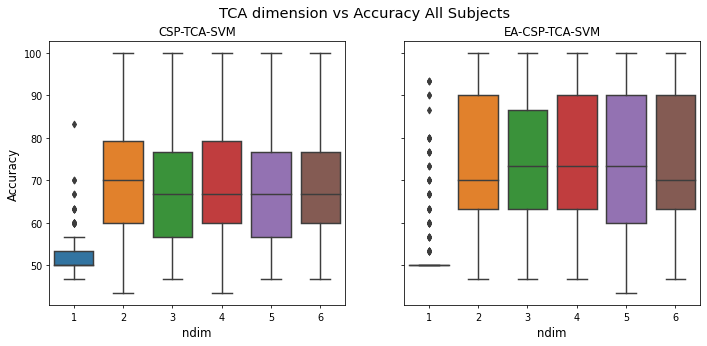

In [42]:
## ======== Boxplot of TCA-dim vs Acc All Subjects Separate Models ======== ##
# Necessary variables
nrow, ncol = 1, 2
models = ['CSP-TCA-SVM', 'EA-CSP-TCA-SVM']
data = data_copy

# Plot
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 5), dpi=70, sharey=True)
fig.suptitle(f'TCA dimension vs Accuracy All Subjects', fontsize='15')

# For each model
for ax, m in zip(axes.ravel(), models):
    ax.set_title(f'{m}')
    ax.set_xlabel('ndim', fontsize=12)
    sns.boxplot(data=data[m]['df'], ax=ax)

axes[0].set_ylabel('Accuracy', fontsize=12)
plt.show()

## `ker-type` vs `acc`
**Goal**: Finding the best pair SVM kernel and TCA kernel, does it affect the accuracy?

**Note:**: 
* Select n-dim = 4
* Do I have to set kernel in svm classifier as well?

In [313]:
%%capture
# Iterate each subject over different dimension
ker_sc    = {}
n_iter    = 5
models    = ['CSP-TCA-SVM', 'EA-CSP-TCA-SVM']
kernels   = ['linear', 'poly', 'rbf']
tca_dim   = 4

for m in models:
    ker_sc[m] = {}
    
    for s in TL_data['tgt'].keys():
        ker_sc[m][s] = {}
        
        # Iterate over kernels for svm
        for svm_k in kernels:
            ker_sc[m][s][f'svm-{svm_k}'] = {}
        
            # Iterate over kernels for tca
            for tca_k in kernels:
                ker_sc[m][s][f'svm-{svm_k}'][f'tca-{tca_k}'] = \
                eval_all_ver6(TL_data, tgt_subj=s, model=m, n_sim=3, tca_ker=tca_k, svm_ker=svm_k, tca_dim=dim, n_samp=30, n_iter=n_iter, return_mean=False)

In [314]:
# === Creating DataFrame Combination of TCA kernel and SVM kernel === #
df_all = pd.DataFrame()
for m in models:
    df_all_subj = pd.DataFrame()
    for s in range(1, 10):
        df_all_svm_k = pd.DataFrame()
        for svm_k in ker_sc[m][s].keys():
            df_one_subj_svm = pd.DataFrame(ker_sc[m][s][svm_k])
            df_one_subj_svm.index.name = 'iter'
            df_one_subj_svm.columns.name = 'tca-kern'
            df_one_subj_svm['svm-kern'] = svm_k
            df_one_subj_svm['model'] = m
            df_one_subj_svm['subj'] = s
            df_one_subj_svm = df_one_subj_svm.melt(id_vars=['subj', 'svm-kern', 'model'], value_vars=['tca-linear', 'tca-poly', 'tca-rbf'], \
                                                   var_name=['tca-kern'], value_name='acc', ignore_index=False)
            
            # Concat all svm kernel
            df_all_svm_k = pd.concat([df_all_svm_k, df_one_subj_svm])

        # Concat over all subject
        df_all_subj = pd.concat([df_all_subj, df_all_svm_k])

    # Concat over all models
    df_all = pd.concat([df_all, df_all_subj])

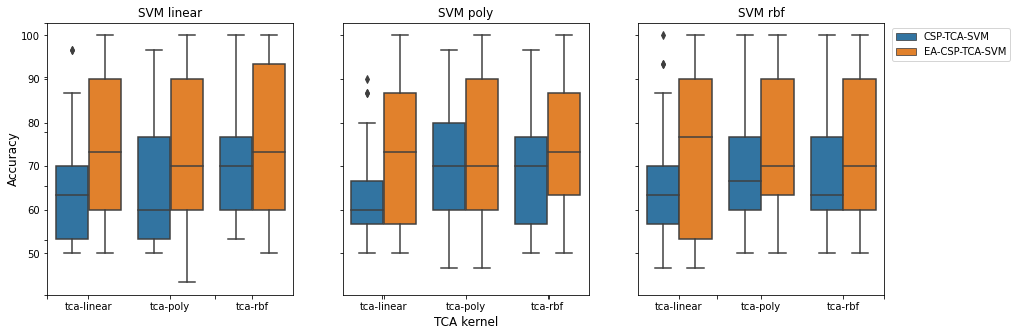

In [316]:
# Variable
nrow = 1
ncol = 3
fsize = (15, 5)
kernels   = ['linear', 'poly', 'rbf']
data = df_all

# Plot
fig, axes = plt.subplots(nrow, ncol, figsize=fsize, sharey=True)

fig.add_subplot(111, frameon=False)

for kern, ax, in zip(kernels, axes.ravel()):
    svm_kern_val = f'svm-{kern}' 
    # print(svm_kern_val)
    ax.set_title(f'SVM {kern}')
    sns.boxplot(x='tca-kern', y='acc', hue='model', data=data[data['svm-kern'] == svm_kern_val], ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()
    ax.set(ylabel='', xlabel='')

ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 1))
plt.tick_params(labelcolor='none')
plt.grid(False)
plt.xlabel('TCA kernel', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.show()

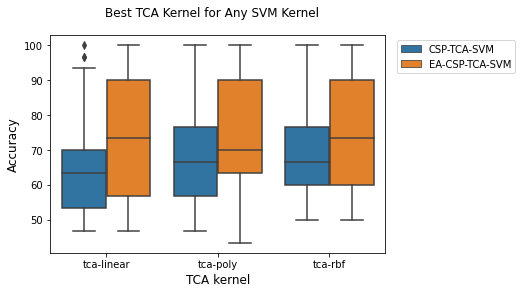

In [326]:
fig, ax = plt.subplots()
fig.suptitle('Best TCA Kernel for Any SVM Kernel')
ax = sns.boxplot(x='tca-kern', y='acc', data=df_all, hue='model')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('TCA kernel', fontsize=12)
plt.show()

Text(0, 0.5, 'asdf')

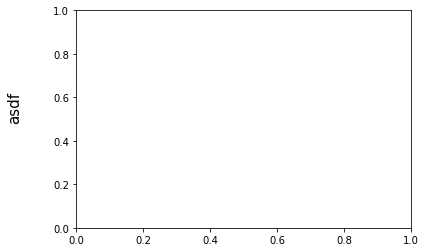

In [233]:
fig, axes = plt.subplots(1,1)

type(fig)
type(axes)

fig.text(0, 0.5, s='asdf', ha='right', rotation='vertical', fontsize=15)

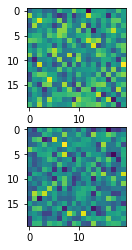

In [258]:
fig2 = plt.figure()
ax3 = fig2.add_subplot(2,1,1)
ax4 = fig2.add_subplot(2,1,2)
ax4.imshow(np.random.randn(20, 20))
ax3.imshow(np.random.randn(20, 20))

In [266]:
type(bigax)

matplotlib.axes._subplots.AxesSubplot

<AxesSubplot:xlabel='tca-kern', ylabel='acc'>

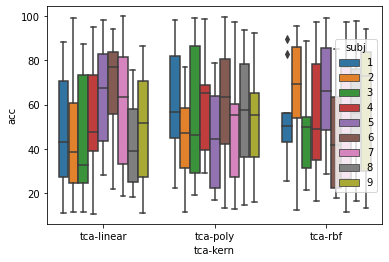

In [197]:
sns.boxplot(x='tca-kern', y='acc', hue='subj', data=df_all[df_all['svm-kern'] == 'svm-rbf'])

In [104]:
df_svm

TCA kern,tca-linear,tca-poly,tca-rbf,SVM kern,subj
iter,,,,,
0,24.856259,21.477047,83.468121,linear,1
1,11.074848,66.410870,98.570201,linear,1
2,54.647140,22.171497,67.408241,linear,1
3,93.666758,23.778166,97.318398,linear,1
4,13.476948,99.908525,96.911747,linear,1


In [49]:
clf = SVC(kernel='poly')
clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [64]:
from sklearn.model_selection import train_test_split, cross_val_score

In [58]:
X, y = sklearn.datasets.load_iris(return_X_y=True)

In [62]:
X_tr, X_te, y_tr, y_te = sklearn.model_selection.train_test_split(X, y, train_size=50)
print(X_tr.shape)
print(X_te.shape)

(50, 4)
(100, 4)


In [68]:
for k in ['linear', 'poly', 'rbf']:
    clf = SVC(kernel=k, coef0=1, degree=3)
    print(f'Currently using {clf.kernel}')
    print(f'5-CV Result: {cross_val_score(clf, X, y, cv=5)}')

Currently using linear
5-CV Result: [ 0.967  1.000  0.967  0.967  1.000]
Currently using poly
5-CV Result: [ 0.967  1.000  0.900  0.967  1.000]
Currently using rbf
5-CV Result: [ 0.967  0.967  0.967  0.933  1.000]


In [66]:
cross_val_score(clf, X, y, cv=5)

array([ 0.967,  1.000,  0.967,  0.967,  1.000])

## `distance metric` vs `acc`

## `n_src_raw` vs `acc` 

## p-value

In [ ]:
%%capture
pval_sc6 = {}
# Models
models = ['CSP-SVM', 'CSP-TCA-SVM', 'EA-CSP-SVM', , 'EA-CSP-TCA-SVM']
# models = ['CSP-TCA-SVM', 'EA-CSP-TCA-SVM']
# models = ['CSP-SVM', 'CSP-TCA-SVM']

# Iterate over all tgt subj
for m in models:
    pval_sc6[m] = {}
    
    for s in TL_data['tgt'].keys():
        pval_sc6[m][s] = eval_all_ver6(TL_data, tgt_subj=s, ker_typ='rbf', tca_dim=4, model=m, n_sim=3, n_samp=30, n_iter=30, return_all=True)

In [56]:
# Try calculating p-value
print(pval_sc6['CSP-SVM'].keys())
print(pval_sc6['CSP-TCA-SVM'].keys())
print(pval_sc6['EA-CSP-TCA-SVM'].keys())
print('')
print(np.round(pval_sc6['CSP-SVM'][1], 2))

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

[ 0.730  0.630  0.600  0.600  0.630  0.570  0.600  0.630  0.670  0.630
  0.630  0.630  0.670  0.500  0.630  0.700  0.670  0.600  0.700  0.630
  0.700  0.770  0.700  0.700  0.670  0.570  0.670  0.730  0.670  0.630]


In [57]:
a = pval_sc6['CSP-SVM'][1]
b = pval_sc6['CSP-TCA-SVM'][1]

In [58]:
from scipy import stats

In [59]:
data = pval_sc6
subjects = range(1, 10)
models = ['CSP-SVM','CSP-TCA-SVM', 'EA-CSP-TCA-SVM']
m1 = 0
m2 = 1

print(f'p value between {models[m1]} and {models[m2]}')
print('==='*15)

if len(data[models[m2]]) != len(data[models[m1]]):
    print('undefined')

# Collect pval
all_pval = []

data1 = np.array([])
data2 = np.array([])

for s in subjects:
    #print(s)
    data1 = np.concatenate([data1, pval_sc6[models[m1]][s]])
    data2 = np.concatenate([data2, pval_sc6[models[m2]][s]])

# print(len(data1))
# print(len(data2))

_, pval = stats.ttest_ind(a=data1, b=data2, equal_var=False)
# print(f'pval between model {models[m1]} and {models[m2]} of subject {s} is {pval:3f} ')
# all_pval.append(pval)

# print('==='*15)
print(f'p value between {models[m1]} and {models[m2]} : {pval:.3f}')
print(f'p value between {models[m1]} and {models[m2]} : {pval:.2e}')

p value between CSP-SVM and CSP-TCA-SVM
p value between CSP-SVM and CSP-TCA-SVM : 0.385
p value between CSP-SVM and CSP-TCA-SVM : 3.85e-01


# Misc

In [188]:
df = pd.DataFrame({'temp_c': [17.0, 25.0]},
                  index=['Portland', 'Berkeley'])

In [189]:
df

,temp_c
Portland,17.0
Berkeley,25.0


In [196]:
df.assign(laa='asdf')

,temp_c,laa
Portland,17.0,asdf
Berkeley,25.0,asdf


In [201]:
A = {}
A[1] = {}
A[1][1] = np.random.uniform(10, 100, 10)
A[1][2] = np.random.uniform(10, 100, 10)
A[1][3] = np.random.uniform(10, 100, 10)

A[2] = {}
A[2][1] = np.random.uniform(10, 100, 10)
A[2][2] = np.random.uniform(10, 100, 10)
A[2][3] = np.random.uniform(10, 100, 10)

In [202]:
A

{1: {1: array([ 31.292,  63.906,  84.485,  77.617,  91.445,  99.252,  90.589,
          30.226,  81.039,  32.984]),
  2: array([ 92.616,  96.668,  95.834,  22.878,  83.009,  76.143,  65.963,
          11.001,  13.601,  91.036]),
  3: array([ 53.190,  49.582,  14.050,  34.763,  36.176,  47.502,  99.191,
          61.195,  38.496,  25.345])},
 2: {1: array([ 86.359,  82.475,  98.651,  57.488,  25.825,  68.613,  39.096,
          35.606,  32.458,  45.721]),
  2: array([ 63.852,  32.474,  76.718,  42.356,  66.464,  68.060,  60.767,
          28.845,  22.672,  41.746]),
  3: array([ 61.975,  77.272,  65.198,  65.979,  67.848,  84.035,  85.444,
          86.958,  57.353,  61.948])}}

In [204]:
dframe(A[1])

,1,2,3
0,31.292015,92.616138,53.190458
1,63.906459,96.668320,49.581634
2,84.484517,95.833826,14.049756
3,77.617049,22.877565,34.763202
4,91.445162,83.009177,36.176079
5,99.251915,76.142659,47.501895
6,90.588588,65.963404,99.190883
7,30.225910,11.000533,61.195350
8,81.039496,13.601080,38.495873
9,32.983806,91.035574,25.345227


In [123]:
A = {}
A['subj'] = [1]*5 + [2]*5 +[3]*5 + [4]*5 + [5]*5
A['ndim'] = ([1,2,3,4,5])*5
A['score']= np.random.uniform(60, 100, 25)

In [124]:
dfA = dframe(A)
dfA.head()

,subj,ndim,score
0,1,1,65.765702
1,1,2,98.328366
2,1,3,60.508561
3,1,4,95.068320
4,1,5,75.150571


<AxesSubplot:xlabel='ndim', ylabel='score'>

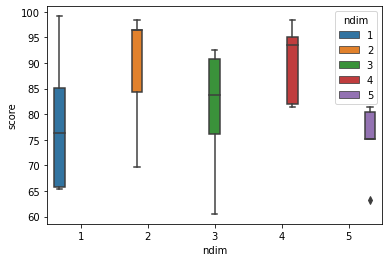

In [128]:
sns.boxplot(data=dfA, x='ndim', y='score', hue='ndim')

In [91]:
([1,2,3,4,5])*5

[1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5]

In [93]:
X = TL_data['tgt'][6]['epochs']
# Xte = TL_data['tgt'][1]['epochs']
y = TL_data['tgt'][6]['y']

In [94]:
X.shape

(144, 22, 750)

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

In [96]:
Xtr, Xte, ytr, yte = train_test_split(X, y, train_size=.8)

print(Xtr.shape)
print(Xte.shape)
print(ytr.shape)
print(yte.shape)

(115, 22, 750)
(29, 22, 750)
(115,)
(29,)


In [97]:
feat_train, feat_test = csp_feat_ver1(Xtr, Xte, ytr)

In [102]:
lda = LDA()
svm = SVC()

In [103]:
svm.fit(feat_train, ytr)

SVC()

In [104]:
svm.score(feat_test, yte)

0.6551724137931034